In [1]:
# Download the dataset

!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis -p .data/ --unzip

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
100%|██████████████████████████████████████| 1.99M/1.99M [00:00<00:00, 5.77MB/s]
100%|██████████████████████████████████████| 1.99M/1.99M [00:00<00:00, 5.33MB/s]


In [2]:
# Load dataset
import pandas as pd
import numpy as np

sentiment = pd.read_csv('.data/twitter_training.csv')
sentiment_validation = pd.read_csv('.data/twitter_validation.csv')

# Add column names
sentiment.columns = ['id', 'tag', 'sentiment', 'text']
sentiment_validation.columns = ['id', 'tag', 'sentiment', 'text']

sentiment

,id,tag,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [3]:
# Filter for Positive/Negative only
sentiment = sentiment[sentiment['sentiment'].isin(['Positive', 'Negative'])]
sentiment_validation = sentiment_validation[sentiment_validation['sentiment'].isin(['Positive', 'Negative'])]

In [4]:
sentiment['sentiment'].value_counts()

sentiment
Negative    22542
Positive    20831
Name: count, dtype: int64

In [5]:
sentiment_validation['sentiment'].value_counts()

sentiment
Positive    277
Negative    266
Name: count, dtype: int64

In [6]:
# Validate that 'text' is not null or empty
sentiment = sentiment.dropna(subset=['text'])
sentiment_validation = sentiment_validation.dropna(subset=['text'])

In [7]:
# Compute an embedding, using BERT.
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

count = 0

# Function to compute the embedding for a single sentence
def get_embedding(text):
    global count
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True, max_length=512)
    outputs = model(inputs)
    count += 1
    if count % 1000 == 0:
        print(f'{count},', end='')
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy().squeeze()

# Compute embeddings for each text in both DataFrames
sentiment['embedding'] = sentiment['text'].apply(get_embedding)
sentiment_validation['embedding'] = sentiment_validation['text'].apply(get_embedding)

# Display the DataFrames with the embeddings
print("Sentiment DataFrame with BERT Embeddings")
print(sentiment.head())

print("\nSentiment Validation DataFrame with BERT Embeddings")
print(sentiment_validation.head())

2024-05-25 16:32:24.573027: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-25 16:32:24.573065: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-25 16:32:24.573075: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-25 16:32:24.573115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 16:32:24.573138: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight',

1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,42000,43000,Sentiment DataFrame with BERT Embeddings
     id          tag sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                                           embedding  
0  [0.19273372, -0.11226941, 0.17335339, -0.18106...  
1  [0.33810177, 0.057169184, 0.4759693, -0.036217...  
2  

In [8]:
# Drop the 'tag' and 'id' columns
sentiment = sentiment.drop(columns=['tag', 'id'])
sentiment_validation = sentiment_validation.drop(columns=['tag', 'id'])

In [18]:
print(sentiment.shape)
print(sentiment_validation.shape)
print(sentiment.head())
# Show the embeddings length
print(sentiment['embedding'].apply(lambda x: len(x)).value_counts())

(43012, 3)
(543, 3)
  sentiment                                               text  \
0  Positive  I am coming to the borders and I will kill you...   
1  Positive  im getting on borderlands and i will kill you ...   
2  Positive  im coming on borderlands and i will murder you...   
3  Positive  im getting on borderlands 2 and i will murder ...   
4  Positive  im getting into borderlands and i can murder y...   

                                           embedding  
0  [0.19273372, -0.11226941, 0.17335339, -0.18106...  
1  [0.33810177, 0.057169184, 0.4759693, -0.036217...  
2  [0.448893, 0.03900575, 0.4786713, -0.005726489...  
3  [0.40309918, -0.035907622, 0.5685759, 0.010016...  
4  [0.43010965, -0.10140726, 0.41650018, -0.09925...  
embedding
768    43012
Name: count, dtype: int64


In [42]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Assuming the embeddings are already added to the DataFrames

# Extract features (embeddings) and labels
X = np.vstack(sentiment['embedding'].values)
y = sentiment['sentiment'].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Test Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


Test Accuracy: 0.8886434964547251
Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.90      0.89      4481
    Positive       0.89      0.87      0.88      4122

    accuracy                           0.89      8603
   macro avg       0.89      0.89      0.89      8603
weighted avg       0.89      0.89      0.89      8603



In [43]:
# Predict on the validation set
X_val = np.vstack(sentiment_validation['embedding'].values)
y_val = sentiment_validation['sentiment'].values

y_val_pred = rf_model.predict(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {accuracy_val}')
print(f'Classification Report:\n{report_val}')

Validation Accuracy: 0.9429097605893186
Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.96      0.94       266
    Positive       0.96      0.92      0.94       277

    accuracy                           0.94       543
   macro avg       0.94      0.94      0.94       543
weighted avg       0.94      0.94      0.94       543



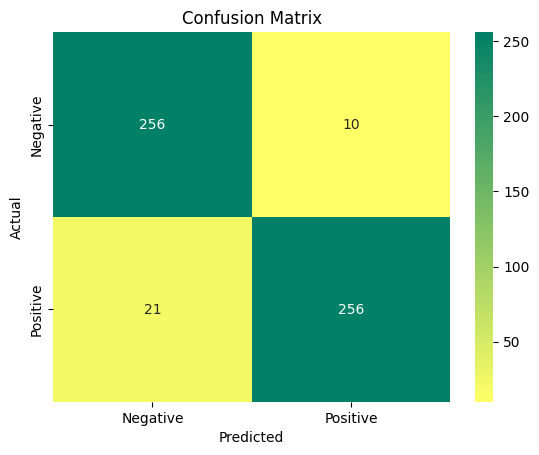

In [44]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='summer_r', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [45]:
import numpy as np
from sklearn.metrics import accuracy_score

# Test sentences with their corresponding true sentiments (Positive/Negative)
test_sentences = [
    ("This icecream is delicious!", "Positive"),
    ("I hate this phone.", "Negative"),
    ("I love this car.", "Positive"),
    ("I don't like this book.", "Negative"),
    ("This sandwich couldn't be worse!", "Negative"),
    ("I'm in love with this song.", "Positive"),
    ("Why is this happening to me?", "Negative"),
    ("This is the worst day ever.", "Negative"),
    ("Ha! Ha! Ha! This is so funny", "Positive"),
    ("I'm so sad right now.", "Negative"),
    ("That phone really sucks.", "Negative"),
    ("What a fantastic performance!", "Positive"),
    ("This place is amazing!", "Positive"),
    ("I'm extremely disappointed in this service.", "Negative"),
    ("This is the best thing ever!", "Positive"),
    ("I can't stand this anymore.", "Negative"),
    ("This movie is a masterpiece.", "Positive"),
    ("I feel utterly miserable.", "Negative"),
    ("What a wonderful surprise!", "Positive"),
    ("This is a total disaster.", "Negative"),
    ("I'm thrilled with the results.", "Positive"),
    ("I detest this kind of behavior.", "Negative"),
    ("This experience was phenomenal.", "Positive"),
    ("I regret buying this product.", "Negative"),
    ("I'm ecstatic about the news!", "Positive"),
    ("This is utterly ridiculous.", "Negative"),
    ("I couldn't be happier with my decision.", "Positive"),
    ("This is an absolute failure.", "Negative"),
    ("I'm over the moon with joy!", "Positive"),
    ("This is the last straw.", "Negative"),
    ("I'm feeling great today!", "Positive"),
    ("This product is amazing!", "Positive"),
    ("I'm very unhappy with this.", "Negative"),
    ("What a terrible experience!", "Negative"),
    ("This is just perfect.", "Positive"),
    ("I love the way this looks.", "Positive"),
    ("I'm so frustrated right now.", "Negative"),
    ("This is absolutely fantastic!", "Positive"),
    ("I can't believe how bad this is.", "Negative"),
    ("I'm delighted with the outcome.", "Positive"),
    ("This is so disappointing.", "Negative"),
    ("What a lovely day!", "Positive"),
    ("I'm completely heartbroken.", "Negative"),
    ("This is pure bliss.", "Positive"),
    ("I despise this kind of thing.", "Negative"),
    ("I'm overjoyed with the results.", "Positive"),
    ("This is simply dreadful.", "Negative"),
    ("I'm very pleased with this.", "Positive"),
    ("This is a nightmare.", "Negative"),
    ("I'm so happy right now!", "Positive"),
    ("This is not acceptable.", "Negative"),
    ("I'm really enjoying this.", "Positive"),
    ("This is absolutely horrible.", "Negative"),
    ("I love spending time here.", "Positive"),
    ("This is the most frustrating thing ever.", "Negative"),
    ("I'm incredibly satisfied with this.", "Positive"),
    ("This is a complete mess.", "Negative"),
    ("What an extraordinary event!", "Positive"),
    ("This is beyond disappointing.", "Negative"),
    ("I'm elated with my progress.", "Positive"),
    ("This is such a waste of time.", "Negative"),
    ("I'm absolutely thrilled!", "Positive"),
    ("This situation is unbearable.", "Negative"),
    ("I can't express how happy I am.", "Positive"),
    ("This is a total failure.", "Negative"),
    ("I'm so grateful for this opportunity.", "Positive"),
    ("This is driving me crazy.", "Negative"),
    ("I'm in awe of this beauty.", "Positive"),
    ("This is utterly pointless.", "Negative"),
    ("I'm having the time of my life!", "Positive"),
    ("This is so infuriating.", "Negative"),
    ("I absolutely love this place.", "Positive"),
    ("This is the worst experience ever.", "Negative"),
    ("I'm overjoyed to be here.", "Positive"),
    ("This is a huge disappointment.", "Negative"),
    ("I'm very content with this.", "Positive"),
    ("This is the most annoying thing.", "Negative"),
    ("I'm extremely happy with the results.", "Positive"),
    ("This is totally unacceptable.", "Negative"),
    ("I'm so excited about this!", "Positive"),
    ("This is very upsetting.", "Negative")
]


# Separate the sentences and their true sentiments
sentences, true_sentiments = zip(*test_sentences)

# Generate embeddings for the test sentences
test_embeddings = np.array([get_embedding(sentence) for sentence in sentences])

# Predict the sentiments using the trained model
predictions = rf_model.predict(test_embeddings)

# Print the results and calculate accuracy
correct_predictions = 0
for sentence, true_sentiment, prediction in zip(sentences, true_sentiments, predictions):
    is_correct = prediction == true_sentiment
    if is_correct:
        correct_predictions += 1
    print(f'Sentence: {sentence}', end=' | ')
    print(f'True Sentiment: {true_sentiment}', end=' | ')
    print(f'Predicted Sentiment: {prediction}', end=' | ')
    print(f'Correct: {is_correct}')
    print()

# Calculate and print the accuracy
accuracy = correct_predictions / len(sentences)
print(f'Accuracy: {accuracy * 100:.2f}%')


TypeError: model() missing 2 required positional arguments: 'X_train' and 'y_train'